# Basics of Zipline API for Trading

1) Creating Basic Framework of zipline code

2) Simulating simple trade strategy (long term strategy):

2.1) buy_ten_stock daily strategy (b_t_s)

2.2) Aroon (up/down) strategy (aroon)

2.3) Dual_moving_average_crossover strategy (d_m_a_c)

2.4) Diversified_portfolio strategy (d_p)

*) Special edition: Coronavirus trading strategies that counter falling airlines stock price (short-mid term straetgy)

Note: Code could be executed automatically daily to get latest data and zipline portfolio trade strategy (changes made to zipline code so first and last date automatically extracted in datetime format from the stock data.

## 1)

## 2)

### 2.1) buy_ten_stock daily strategy (b_t_s)

In [1]:
# package to extract stock data from alpha_vantage API
from alpha_vantage.timeseries import TimeSeries

# package to plot 
import matplotlib.pyplot as plt

# package to check and set directory
import os

# package to use pandas DataFrame or Pandas
import pandas as pd

# packages to execute excel spreadsheet conversion function
import openpyxl
import xlrd

# Required to set datetimes for zipline algorithm later
import pytz

In [2]:
# get current directory
os.getcwd()

'C:\\Users\\UX330\\Documents\\A Uni\\Git\\Python project self research\\Project 1'

In [3]:
# set path as current directory
os.chdir('C:\\Users\\UX330\\Documents\\A Uni\\Git\\Python project self research\\Project 1')

In [4]:
# Execute functions with API keys
with open('ak.txt', 'r') as myFile:
    keys=myFile.read()
    ts=TimeSeries(key=keys, output_format='pandas')

In [5]:
# Extract data of interest('MSFT' stock this case)
# msft=Microsoft, cat=Caterpillar
# msft_day being data by msf OHLC data by daily basis, for long term startegy
# msft_intra being data by msf OHLC data by intraday basis(per 15 minute), for short term strategy

columns=['open', 'volume', 'low', 'close', 'high']
msft_day, meta_data=ts.get_daily(symbol='MSFT', outputsize='full')
msft_intra, meta_data=ts.get_intraday(symbol='MSFT',interval='5min', outputsize='full')
# Caterpillar stock data will be used later in Part 4
cat_day, meta_data=ts.get_daily(symbol='CAT', outputsize='full')
cat_intra, meta_data=ts.get_intraday(symbol='CAT', interval='5min', outputsize='full')

In [6]:
msft_day.head()

,2. high,5. volume,4. close,1. open,3. low
date,,,,,
2000-03-10,102.50,42794500.0,101.00,99.56,99.50
2000-03-13,100.25,30915900.0,98.00,97.62,97.50
2000-03-14,99.25,36744600.0,95.12,98.62,95.12
2000-03-15,96.62,26604000.0,95.37,94.56,93.69
2000-03-16,96.69,38650400.0,95.37,95.94,93.25


In [7]:
msft_intra.head()

,2. high,5. volume,4. close,1. open,3. low
date,,,,,
2020-02-20 09:35:00,187.25,890163.0,187.1100,186.98,186.4800
2020-02-20 09:40:00,186.99,387255.0,186.7354,186.99,186.4400
2020-02-20 09:45:00,186.77,282779.0,186.4700,186.77,186.4700
2020-02-20 09:50:00,186.47,571388.0,185.9647,186.47,185.9647
2020-02-20 09:55:00,186.55,388597.0,186.4100,186.01,186.0100


In [8]:
# Function that exports Dataframe(d0) to excel spreadsheet to be extracted in excel format
# Only such data format can be accepted by the zipline algorithm function
from collections import OrderedDict

stock_datas=[msft_day, msft_intra, cat_day, cat_intra]
data_1, data_2, data_3, data_4 = OrderedDict(), OrderedDict(), OrderedDict(), OrderedDict()
#all_dict=[data_1, data_2, data_3, data_4]
path_1=r'C:\\Users\\UX330\\Documents\\A Uni\\Git\\Python project self research\\Project 1\\csvdir\\daily\\msft_day.xlsx'
path_2=r'C:\\Users\\UX330\\Documents\\A Uni\\Git\\Python project self research\\Project 1\\csvdir\\daily\\msft_intra.xlsx'
path_3=r'C:\\Users\\UX330\\Documents\\A Uni\\Git\\Python project self research\\Project 1\\csvdir\\daily\\cat_day.xlsx'
path_4=r'C:\\Users\\UX330\\Documents\\A Uni\\Git\\Python project self research\\Project 1\\csvdir\\daily\\cat_intra.xlsx'
paths=[path_1, path_2, path_3, path_4]
names=['MSFT_day', 'MSFT_intra', 'CAT_day', 'CAT_intra']

def data_format(stock_data, all_paths, all_names):
    for datas, dicts, path, name in zip(stock_data, [data_1, data_2, data_3, data_4], all_paths, all_names):
        #dicts=OrderedDict()
        data_ex=datas.to_excel(path)
        dicts[name]=pd.read_excel(path, index_col='date')
        # Remove excel file so new data can be generated with the same .xlsx file name tommorow(daily)
        os.remove(path)

data_format(stock_datas, paths, names)

print(data_2['MSFT_intra'].tail()) # Output display

                     2. high  5. volume  4. close  1. open  3. low
date                                                              
2020-03-11 15:40:00   155.25     936059    154.83  154.045  153.64
2020-03-11 15:45:00   155.72     987342    154.45  154.790  154.18
2020-03-11 15:50:00   154.66     874072    154.48  154.450  153.58
2020-03-11 15:55:00   154.77    1730824    152.96  154.470  152.96
2020-03-11 16:00:00   154.71    2449457    153.58  152.970  152.96


In [9]:
# Function that converts dataframe to panels
# minor_axis being axis 1, major_axis being axis 2
# localizing date by utc timezone for major_axis
# axis 1 consisting of stock name 'AAPL'
# axis 2 consisting of 5 column names (close, high, open, low, volume)
# axis 3 consisting of all datas of the 5 column names for each date

rep_col=[columns, columns, columns, columns]
panel_1, panel_2, panel_3, panel_4=pd.Panel(data_1), pd.Panel(data_2), pd.Panel(data_3), pd.Panel(data_4)
panels=[panel_1, panel_2, panel_3, panel_4]

def df_to_panel(col_names, all_panels):
    for columns, panel in zip(col_names, all_panels):
        panel.minor_axis = columns
        panel.major_axis = panel.major_axis.tz_localize(pytz.utc)

df_to_panel(rep_col, panels)
print(panel_1)

<class 'pandas.core.panel.Panel'>
Dimensions: 1 (items) x 5032 (major_axis) x 5 (minor_axis)
Items axis: MSFT_day to MSFT_day
Major_axis axis: 2000-03-10 00:00:00+00:00 to 2020-03-11 00:00:00+00:00
Minor_axis axis: open to high


In [10]:
# b_t_s being short notation of buy ten stocks daily strategy

from zipline.api import order, record, symbol, set_benchmark
import zipline
from datetime import datetime


def initialize_b_t_s(context):
    # adds Series data formatting to results for algorithm performance comparison with benchmark('AAPL')
    set_benchmark(symbol("MSFT_day"))


def handle_data_b_t_s(context, data):
    # Example strategy
    # Order 10 MSFT stocks everyday as long as there is still enough cash(initial capital-stock hold value)
    # Record all data (some are self generated from algorithm, shown below in Out[17])
    order(symbol("MSFT_day"), 10)
    record(MSFT=data.current(symbol('MSFT_day'), 'price'))

# Run zipline algorithm with necessary inputs like time period, 
# initialize(def), handle_data(def), capital, and data(panel)
# start(frst date of data), end(last date of data)
b_t_s_perf = zipline.run_algorithm(start=panel_1['MSFT_day'].index.min().to_pydatetime(),
                      end=panel_1['MSFT_day'].index.max().to_pydatetime(),
                      capital_base=100000,
                      initialize=initialize_b_t_s,
                      handle_data=handle_data_b_t_s,
                      data=panel_1)

In [11]:
# Below shows all the output data produced from the algorithm
b_t_s_perf.head()

,MSFT,algo_volatility,algorithm_period_return,alpha,benchmark_period_return,benchmark_volatility,beta,capital_used,ending_cash,ending_exposure,...,short_exposure,short_value,shorts_count,sortino,starting_cash,starting_exposure,starting_value,trading_days,transactions,treasury_period_return
2000-03-10 21:00:00+00:00,99.56,NaN,0.000000,NaN,-0.028683,NaN,NaN,0.0000,100000.0000,0.0,...,0.0,0.0,0,NaN,100000.0000,0.0,0.0,1,[],0.0
2000-03-13 21:00:00+00:00,97.62,0.000056,-0.000005,-0.003915,-0.047610,0.103238,-0.000542,-976.6981,99023.3019,976.2,...,0.0,0.0,0,-11.224972,100000.0000,0.0,0.0,2,"[{'amount': 10, 'sid': Equity(0 [MSFT_DAY]), '...",0.0
2000-03-14 21:00:00+00:00,98.62,0.000894,0.000090,0.016053,-0.037854,0.322981,0.002666,-986.7031,98036.5988,1972.4,...,0.0,0.0,0,165.580803,99023.3019,976.2,976.2,3,"[{'amount': 10, 'sid': Equity(0 [MSFT_DAY]), '...",0.0
2000-03-15 21:00:00+00:00,94.56,0.006760,-0.000727,0.024627,-0.077463,0.347579,0.014131,-946.0828,97090.5160,2836.8,...,0.0,0.0,0,-7.062611,98036.5988,1972.4,1972.4,4,"[{'amount': 10, 'sid': Equity(0 [MSFT_DAY]), '...",0.0
2000-03-16 21:00:00+00:00,95.94,0.007203,-0.000318,0.033896,-0.064000,0.387474,0.015348,-959.8897,96130.6263,3837.6,...,0.0,0.0,0,-2.758515,97090.5160,2836.8,2836.8,5,"[{'amount': 10, 'sid': Equity(0 [MSFT_DAY]), '...",0.0


In [12]:
b_t_s_perf[['starting_cash', 'ending_cash', 'capital_used']].head()
# As shown above, zipline algoritm returns interesting outputs (volatiity, alpha value, beta value, ending_cash,...etc)

# ending_cash is the amount of capital(in cash) left at the end of the time period
# starting_cash-capital_used=ending_cash of that date

,starting_cash,ending_cash,capital_used
2000-03-10 21:00:00+00:00,100000.0000,100000.0000,0.0000
2000-03-13 21:00:00+00:00,100000.0000,99023.3019,-976.6981
2000-03-14 21:00:00+00:00,99023.3019,98036.5988,-986.7031
2000-03-15 21:00:00+00:00,98036.5988,97090.5160,-946.0828
2000-03-16 21:00:00+00:00,97090.5160,96130.6263,-959.8897


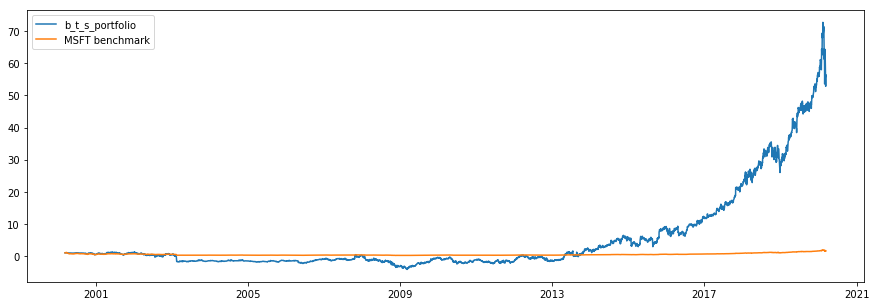

In [13]:
# Plotting MSFT benchmark and portfolio cumulative daily returns to understand b_t_s trade strategy performance
plt.figure(figsize=(15,5))
b_t_s_portfolio_daily_ret=b_t_s_perf.portfolio_value.pct_change()
MSFT_daily_ret=b_t_s_perf.MSFT.pct_change()

plt.plot((1+b_t_s_portfolio_daily_ret).cumprod())
plt.plot((1+MSFT_daily_ret).cumprod())

plt.legend(('b_t_s_portfolio', 'MSFT benchmark'), loc=0)

plt.show()

# Summary on b_t_s strategy (buy and hold stock, long term):

- Strategy would not be profitable in early to mid years as portfolio returns remains below the MSFT benchmark.

- Strategy would be profitable only in late years if investor decides to stick to the b_t_s strategy despite lower early mid years returns as portfolio returns rises around after year 2013

- Valid as a long term strategy.

### 2.2) Aroon (up/down) strategy (aroon)

In [14]:
from zipline.api import order, order_target_percent, record, symbol, set_benchmark, get_open_orders 
import zipline
from datetime import datetime

# nanargmax extracts index of max value excluding any NaN values
# nanargmin extracts index of min value excluding any NaN values
from zipline.utils.math_utils import (
    nanargmax,
    nanargmin,
)

def initialize_aroon(context, window_length=42):
    set_benchmark(symbol("MSFT_day"))
    context.stock=symbol("MSFT_day")
    context.window=window_length
    context.counter=0
    context.hold=0
    
def handle_data_aroon(context, data):
    # Example strategy
    # Aroon_up: Extract index of (max 'high' price of stock of the window_length), then multiplied by*100, divided by window_length-1
    # Aroon_down: Extract index of (min 'low' price of stock of the window_length), then multiplied by*100, divided by window_length-1
    # If Aroon_up>70 & Aroon_down<30, buy stock (Aroon value implies more likely strong upward price trend)
    # If Aroon_up<30 & Aroon_down>70, do nothing (Aroon value implies more likely strong downard price trend)
    
    record(MSFT=data.current(symbol('MSFT_day'), 'price'))
    context.counter=context.counter+1
    
    # If stetment staes that below code not executed unless for first 42 data points since window_length is 42
    if context.counter<42:
        return
    
    window_length = context.window
    high_date_index = nanargmax(data.history(context.stock, 'high', 42, '1d'))
    low_date_index = nanargmin(data.history(context.stock, 'low', 42, '1d'))
    
    aroon_up=(100*high_date_index)/(window_length-1)
    aroon_down=(100*low_date_index)/(window_length-1)
    
    
    open_orders=get_open_orders()
    # if statement of open_orders to ensure there is still enough cash to buy stock or else don't buy
    if context.stock not in open_orders:
        if aroon_up>70 and aroon_down<30:
            order_target_percent(context.stock, 1.0)
        
        elif aroon_up<30 and aroon_down>70:
            order_target_percent(context.stock, 0.0)
            
        else:
            pass
        
    record(MSFT=data.current(symbol("MSFT_day"), 'price'), Aroon_up=aroon_up, Aroon_down=aroon_down)

aroon_perf = zipline.run_algorithm(start=panel_1['MSFT_day'].index.min().to_pydatetime(),
                                   end=panel_1['MSFT_day'].index.max().to_pydatetime(),
                                   capital_base=100000,
                                   initialize=initialize_aroon,
                                   handle_data=handle_data_aroon,
                                   data=panel_1)
                                   
                    

C:\Users\UX330\Anaconda3\envs\env_zipline\lib\site-packages\empyrical\stats.py:790: RuntimeWarning: invalid value encountered in true_divide
  np.divide(average_annual_return, annualized_downside_risk, out=out)
C:\Users\UX330\Anaconda3\envs\env_zipline\lib\site-packages\empyrical\stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,


<Figure size 432x288 with 0 Axes>

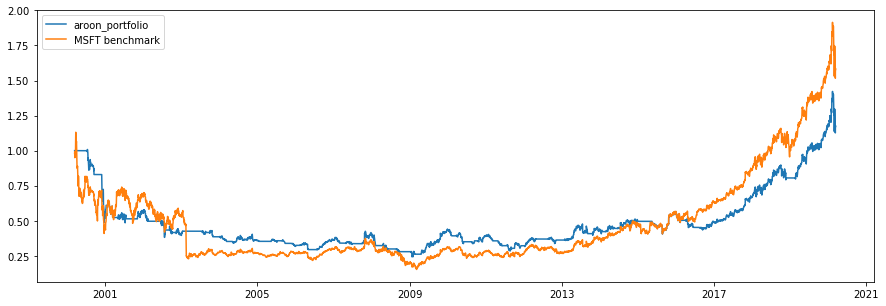

In [15]:
# Plotting MSFT benchmark and portfolio cumulative daily returns to understand aroon trade strategy performance
plt.clf()
plt.figure(figsize=(15,5))
aroon_portfolio_daily_ret=aroon_perf.portfolio_value.pct_change()
MSFT_daily_ret=aroon_perf.MSFT.pct_change()

plt.plot((1+aroon_portfolio_daily_ret).cumprod())
plt.plot((1+MSFT_daily_ret).cumprod())

plt.legend(('aroon_portfolio', 'MSFT benchmark'), loc=0)

plt.show()

# Summary on aroon_strategy (buy and hold stock):

- Strategy has performed well above the MSFT benchmark returns throughout the years even during the economy crisis(2008-2009)

- But compared to b_t_s startegy, the long term profit from would be lower (only 2.5+ for aroon, 20+ for b_t_s, that is if investor even decides to hold on to stocks despite economy crisis...)

- Might be best suited for a short/mid term strategy (since profit margin is not big but strategy returns are not extremely volatile, maintaining above the benchmark returns)

### 2.3) Dual_moving_average_crossover strategy (d_m_a_c)

In [16]:
# d_m_a_c being short notation of dual moving average crossover strategy

from zipline.api import order, order_target_percent, record, symbol, set_benchmark, get_open_orders
import zipline
from datetime import datetime


def initialize_d_m_a_c(context):
    # adds Series data formatting to results for algorithm performance comparison with benchmark('AAPL')
    set_benchmark(symbol('MSFT_day'))
    context.stock=symbol('MSFT_day')
    context.i=0

def handle_data_d_m_a_c(context, data):
    # Example strategy
    # Order MSFT stocks everyday as long as there is still enough cash(initial capital-stock hold value)
    # If long moving average > short moving average, hold stock(do nothing)
    # If long moving average < short moving average, buy stock
    
    record(MSFT=data.current(symbol('MSFT_day'), 'price'))
    
    context.i=context.i+1

    # If statement states that below code not executed for first 250 data points since largest window_length os 250
    if context.i<250:
        #print(context.i)
        return
    
    msft_smavg = data.history(context.stock, 'price', bar_count=50, frequency="1d").mean()
    msft_lmavg = data.history(context.stock, 'price', bar_count=250, frequency="1d").mean()
    
    open_orders = get_open_orders()
    
    if context.stock not in open_orders:
        if msft_smavg>msft_lmavg:
            order_target_percent(context.stock, 1.0)
    
        elif msft_smavg<msft_lmavg:
            order_target_percent(context.stock, 0.0)
    
    record(MSFT=data.current(symbol('MSFT_day'), 'price'), short_mavg=msft_smavg, long_mavg=msft_lmavg)

d_m_a_c_perf = zipline.run_algorithm(start=panel_1['MSFT_day'].index.min().to_pydatetime(),
                      end=panel_1['MSFT_day'].index.max().to_pydatetime(),
                      capital_base=100000,
                      initialize=initialize_d_m_a_c,
                      handle_data=handle_data_d_m_a_c,
                      data=panel_1)

C:\Users\UX330\Anaconda3\envs\env_zipline\lib\site-packages\empyrical\stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
C:\Users\UX330\Anaconda3\envs\env_zipline\lib\site-packages\empyrical\stats.py:790: RuntimeWarning: invalid value encountered in true_divide
  np.divide(average_annual_return, annualized_downside_risk, out=out)


In [17]:
# Note that first 250 days of output return data would be NaN or zero as long_mvag window length is 250
# So would the ending_cash remain the same for the first 250 day period
d_m_a_c_perf[:100]

,MSFT,algo_volatility,algorithm_period_return,alpha,benchmark_period_return,benchmark_volatility,beta,capital_used,ending_cash,ending_exposure,...,short_mavg,short_value,shorts_count,sortino,starting_cash,starting_exposure,starting_value,trading_days,transactions,treasury_period_return
2000-03-10 21:00:00+00:00,99.56,NaN,0.0,NaN,-0.028683,NaN,NaN,0.0,100000.0,0.0,...,NaN,0.0,0,NaN,100000.0,0.0,0.0,1,[],0.0
2000-03-13 21:00:00+00:00,97.62,0.0,0.0,0.0,-0.047610,0.103238,0.0,0.0,100000.0,0.0,...,NaN,0.0,0,NaN,100000.0,0.0,0.0,2,[],0.0
2000-03-14 21:00:00+00:00,98.62,0.0,0.0,0.0,-0.037854,0.322981,0.0,0.0,100000.0,0.0,...,NaN,0.0,0,NaN,100000.0,0.0,0.0,3,[],0.0
2000-03-15 21:00:00+00:00,94.56,0.0,0.0,0.0,-0.077463,0.347579,0.0,0.0,100000.0,0.0,...,NaN,0.0,0,NaN,100000.0,0.0,0.0,4,[],0.0
2000-03-16 21:00:00+00:00,95.94,0.0,0.0,0.0,-0.064000,0.387474,0.0,0.0,100000.0,0.0,...,NaN,0.0,0,NaN,100000.0,0.0,0.0,5,[],0.0
2000-03-17 21:00:00+00:00,95.25,0.0,0.0,0.0,-0.070732,0.348536,0.0,0.0,100000.0,0.0,...,NaN,0.0,0,NaN,100000.0,0.0,0.0,6,[],0.0
2000-03-20 21:00:00+00:00,98.75,0.0,0.0,0.0,-0.036585,0.431961,0.0,0.0,100000.0,0.0,...,NaN,0.0,0,NaN,100000.0,0.0,0.0,7,[],0.0
2000-03-21 21:00:00+00:00,96.75,0.0,0.0,0.0,-0.056098,0.408988,0.0,0.0,100000.0,0.0,...,NaN,0.0,0,NaN,100000.0,0.0,0.0,8,[],0.0
2000-03-22 21:00:00+00:00,102.81,0.0,0.0,0.0,0.003024,0.530799,0.0,0.0,100000.0,0.0,...,NaN,0.0,0,NaN,100000.0,0.0,0.0,9,[],0.0
2000-03-23 21:00:00+00:00,106.81,0.0,0.0,0.0,0.042049,0.535710,0.0,0.0,100000.0,0.0,...,NaN,0.0,0,NaN,100000.0,0.0,0.0,10,[],0.0


In [18]:
# starting_cash-ending_cash=capital_used
d_m_a_c_perf[['starting_cash', 'ending_cash', 'capital_used']][350:360]

,starting_cash,ending_cash,capital_used
2001-07-31 20:00:00+00:00,21.868635,21.868635,0.0
2001-08-01 20:00:00+00:00,21.868635,21.868635,0.0
2001-08-02 20:00:00+00:00,21.868635,21.868635,0.0
2001-08-03 20:00:00+00:00,21.868635,21.868635,0.0
2001-08-06 20:00:00+00:00,21.868635,21.868635,0.0
2001-08-07 20:00:00+00:00,21.868635,21.868635,0.0
2001-08-08 20:00:00+00:00,21.868635,21.868635,0.0
2001-08-09 20:00:00+00:00,21.868635,21.868635,0.0
2001-08-10 20:00:00+00:00,21.868635,21.868635,0.0
2001-08-13 20:00:00+00:00,21.868635,21.868635,0.0


<Figure size 432x288 with 0 Axes>

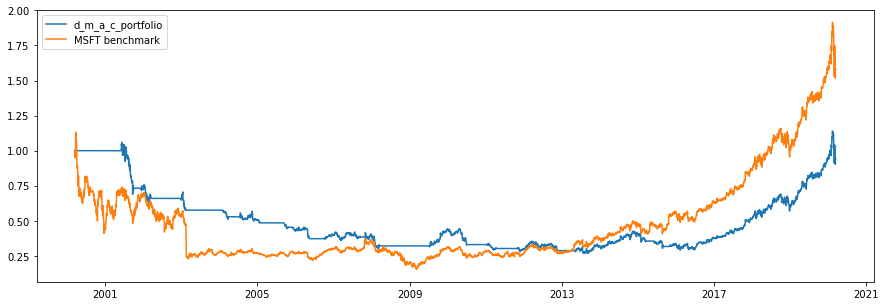

In [19]:
# Plotting MSFT benchmark and portfolio cumulative daily returns to understand d_m_a_c_trade strategy long term performance
plt.clf()
plt.figure(figsize=(15,5))
d_m_a_c_portfolio_daily_ret=d_m_a_c_perf.portfolio_value.pct_change()
MSFT_daily_ret=d_m_a_c_perf.MSFT.pct_change()

plt.plot((1+d_m_a_c_portfolio_daily_ret).cumprod())
plt.plot((1+MSFT_daily_ret).cumprod())

plt.legend(('d_m_a_c_portfolio','MSFT benchmark'), loc=0)

plt.show()

# Summary on d_m_a_c_strategy (buy and hold stock):

- Strategy has performed average with returns being only slightly above MSFT benchmark returns throughout the years, returns are practically a little above benchmark returns during economy crisis(2008-2009)

- The strategy then performed poorly lately by rising slower than MSFT benchmark returns

- In short, this strategy would not be suitable for this stock as a long term strategy.

### 2.4) Portfolio of Assets (Diversified_portfolio strategy, d_p)

In [20]:
# Choose to extract these stock data now because maximum API call frequency is 5 per minute for free version
# Note: This strategy being similar to investing all you can at start date of data unlike previous strategies
# Portfolio now consists of MSFT, CAT, AMZN, KO stock data
# amzn=Amazon, coke=Coke

amzn_day, meta_data=ts.get_daily(symbol='AMZN', outputsize='full')
amzn_intra, meta_data=ts.get_intraday(symbol='AMZN', interval='5min', outputsize='full')
coke_day, meta_data=ts.get_daily(symbol='COKE', outputsize='full')
coke_intra, meta_data=ts.get_intraday(symbol='COKE', interval='5min', outputsize='full')

In [21]:
# Reshape columns to only having close prices

a=msft_day; b=msft_intra; c=cat_day; d=cat_intra
e=amzn_day; f=amzn_intra; g=coke_day; h=coke_intra
stock_data=[a,b,c,d,e,f,g,h]

def reshape_column(all_stocks):
    for stock in all_stocks:
        stock.drop(['5. volume', '1. open', '3. low', '2. high'], axis=1, inplace=True)

reshape_column(stock_data)

In [22]:
# Data display
amzn_day.head()

,4. close
date,
2000-03-10,66.88
2000-03-13,65.31
2000-03-14,65.63
2000-03-15,63.75
2000-03-16,66.25


In [23]:
# Understading correlations between stocks from different stock sectors
# msft~IT sector, cat~Industrial sector, amzn~Consumer Discretionary sector, coke~Consumer Staples sector
# Details at: https://www.timothysykes.com/blog/different-stock-sectors/

stock_close=pd.concat([msft_day['4. close'], cat_day['4. close'], amzn_day['4. close'], coke_day['4. close']], axis=1)
stock_close.columns=['MSFT close', 'CAT close', 'AMZN close', 'COKE close']
stock_close.corr()

# Comments:
# Both AMZN and COKE seemed o be quite closely (+) correlated
# Second in line would be AMZN and MSFT
# Among all stocks, MSFT and CAT are least correlated

,MSFT close,CAT close,AMZN close,COKE close
MSFT close,1.000000,0.552440,0.860897,0.798845
CAT close,0.552440,1.000000,0.792649,0.690278
AMZN close,0.860897,0.792649,1.000000,0.912834
COKE close,0.798845,0.690278,0.912834,1.000000


In [24]:
##### Assumed equal porfolio weight for each stockn (25% each), any weight distribution being possible in reality
# Add normal returns, updated weights by time period, and each stock's total value 
# with initial capital 100000 (same intial capital as previous examples for easy comparison)

weights=[0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25]

def norm_ret_and_weight(all_stocks, weightage):
    initial_capital=100000
    for stock, weight in zip(all_stocks, weightage):
        stock['Norm returns']=stock['4. close']/stock.iloc[0]['4. close']
        stock['Weighted value']=stock['Norm returns']*weight
        stock['Total value']=stock['Weighted value']*initial_capital

norm_ret_and_weight(stock_data, weights)

In [25]:
# Data display
coke_day.head()

,4. close,Norm returns,Weighted value,Total value
date,,,,
2000-03-10,51.13,1.000000,0.250000,25000.000000
2000-03-13,51.03,0.998044,0.249511,24951.105026
2000-03-14,51.69,1.010952,0.252738,25273.811852
2000-03-15,52.00,1.017015,0.254254,25425.386270
2000-03-16,52.00,1.017015,0.254254,25425.386270


In [26]:
# Now add all stock values together providing total portfolio value
port=pd.concat([msft_day['Total value'], cat_day['Total value'], amzn_day['Total value'], coke_day['Total value']], axis=1)
port.columns=['MSFT value', 'CAT value', 'AMZN value', 'COKE value']
port['Portfolio Value']=port.sum(axis=1)

# Display data
port.head()

,MSFT value,CAT value,AMZN value,COKE value,Portfolio Value
date,,,,,
2000-03-10,25000.000000,25000.000000,25000.000000,25000.000000,100000.000000
2000-03-13,24257.425743,24957.971421,24413.127990,24951.105026,98579.630180
2000-03-14,23544.554455,25084.057159,24532.745215,25273.811852,98435.168682
2000-03-15,23606.435644,26793.219389,23829.994019,25425.386270,99655.035322
2000-03-16,23606.435644,28502.381620,24764.503589,25425.386270,102298.707122


In [27]:
# Standard deviation of returns

print('MSFT')
print((msft_day['4. close'].pct_change()).std())
print('CAT')
print((cat_day['4. close'].pct_change()).std())
print('AMZN')
print((amzn_day['4. close'].pct_change()).std())
print('COKE')
print((coke_day['4. close'].pct_change()).std())
print('Port')
print((port['Portfolio Value'].pct_change()).std())

# Comments:
# Diversified portfolio has lowest std, with AMZN having highest std

MSFT
0.020189877970681502
CAT
0.0212077966243293
AMZN
0.03236914239685857
COKE
0.020009181134460347
Port
0.01648726662107361


In [28]:
# Daily(expected) returns

print('MSFT')
print((msft_day['4. close'].pct_change()).mean())
print('CAT')
print((cat_day['4. close'].pct_change()).mean())
print('AMZN')
print((amzn_day['4. close'].pct_change()).mean())
print('COKE')
print((coke_day['4. close'].pct_change()).mean())
print('Port')
print((port['Portfolio Value'].pct_change()).mean())

# Comments:
# Diversified portfolio has higher daily returns comoared to MSFT stock, with AMZN the highest daily returns

MSFT
0.0002989559891377194
CAT
0.0004436641291425323
AMZN
0.0011712683804204129
COKE
0.00047799015476355166
Port
0.0005723257064637762


In [29]:
# Sharpe Ratio, assuming risk-free rate being 0

print('MSFT')
print((msft_day['4. close'].pct_change(1)).mean()/msft_day['4. close'].pct_change(1).std())

print('CAT')
print((cat_day['4. close'].pct_change(1)).mean()/cat_day['4. close'].pct_change(1).std())

print('AMZN')
print((amzn_day['4. close'].pct_change(1)).mean()/amzn_day['4. close'].pct_change(1).std())

print('COKE')
print((coke_day['4. close'].pct_change(1)).mean()/coke_day['4. close'].pct_change(1).std())

print('Port')
print((port['Portfolio Value'].pct_change(1)).mean()/port['Portfolio Value'].pct_change(1).std())

# Comments:
# Diversified portfolio has higher Sharpe Ratio than MSFT stock, only slightly lower than AMZN sharpe ratio

MSFT
0.014807221201229886
CAT
0.020919859663005573
AMZN
0.03618472080786683
COKE
0.023888541542579383
Port
0.034713195317181554


<Figure size 1152x432 with 0 Axes>

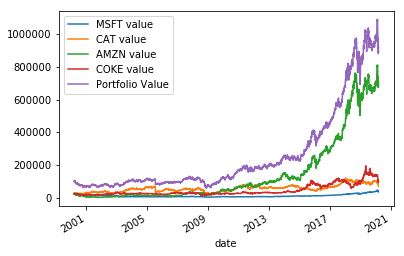

In [30]:
# Plot value proportion of each stock and total portfolio
plt.figure(figsize=(16,6))
port.plot()

<Figure size 432x288 with 0 Axes>

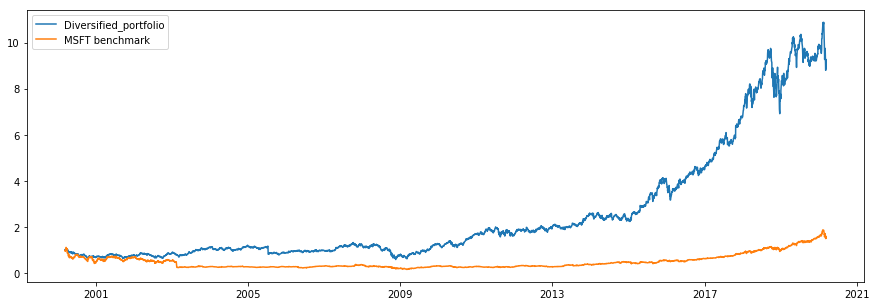

In [31]:
# Plotting MSFT benchmark and portfolio cumulative daily returns to understand d_s_trade strategy long term performance
# Below graphical representation would be same even with 100000 initia1 capital investment in MSFT stock compared 
# to diversification strategy since pct_change() being % change (returns)

plt.clf()
plt.figure(figsize=(15,5))
port_daily_ret=port['Portfolio Value'].pct_change()
MSFT_daily_ret=msft_day['4. close'].pct_change()

plt.plot((1+port_daily_ret).cumprod())
plt.plot((1+MSFT_daily_ret).cumprod())

plt.legend(('Diversified_portfolio','MSFT benchmark'), loc=0)

plt.show()

# Summary on d_p strategy (buy all you can at start date):

- Strategy has performed well with returns being above MSFT benchmark throughout the whole period even during the 2008 economic crisis.

- In addition to the lower std, higher daily(expected) returns, and higher Sharpe Ratio compared to MSFT stock until recent date, it shows that diversification is also a worthy investment strategy instead of putting all eggs in one basket.

- It is also true that one would instead put all of their invetments in AMZN stock but the high std might prove to be   exteremely risky in comparison to d_p strategy but in the end it all comes down to investor's risk profile to decide investment preferences.

# *** Special edition: Coronavirus trading strategies that counter falling airlines stock price (short-mid term straetgy)

In [32]:
# Extract data of from airline stocks
# UAL= United Airlines
# data extracte by daily basis, for long term startegy

columns=['open', 'volume', 'low', 'close', 'high']
ual_day, meta_data=ts.get_daily(symbol='UAL', outputsize='full')

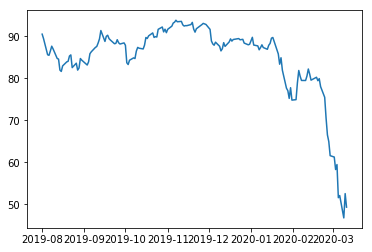

In [33]:
# Reorganize airline data to start from 2019-08-01 and plot closing price
ual_day=ual_day[3394:]
plt.plot(ual_day['4. close'])

In [34]:
# Function that exports Dataframe to excel spreadsheet to be extracted in excel format
# Only such data format can be accepted by the zipline algorithm function
from collections import OrderedDict

stock_datas=[ual_day]
data_2= OrderedDict()

path_2=r'C:\\Users\\UX330\\Documents\\A Uni\\Git\\Python project self research\\Project 1\\csvdir\\daily\\ual_day.xlsx'

paths=[path_2]
names=['UAL_day']

def data_format(stock_data, all_paths, all_names):
    for datas, dicts, path, name in zip(stock_data, [data_2], all_paths, all_names):
        data_ex=datas.to_excel(path)
        dicts[name]=pd.read_excel(path, index_col='date')
        # Remove excel file so new data can be generated with the same .xlsx file name tommorow(daily)
        os.remove(path)

data_format(stock_datas, paths, names)

print(data_2['UAL_day'].tail()) # Output display

            2. high  5. volume  4. close  1. open   3. low
date                                                      
2020-03-05    57.16   13974729     51.59   57.110  50.9300
2020-03-06    56.00   16492236     52.10   48.610  48.2601
2020-03-09    50.99   12307563     46.78   49.585  45.9150
2020-03-10    54.33   15642906     52.56   51.000  46.6200
2020-03-11    51.23   10873681     49.34   50.530  48.0500


In [35]:
# Function that converts dataframe to panels
# minor_axis being axis 1, major_axis being axis 2
# localizing date by utc timezone for major_axis
# axis 1 consisting of stock name 'AAL'
# axis 2 consisting of 5 column names (close, high, open, low, volume)
# axis 3 consisting of all datas of the 5 column names for each date

rep_col=[columns]
panel_2=pd.Panel(data_2)
panels=[panel_2]

def df_to_panel(col_names, all_panels):
    for columns, panel in zip(col_names, all_panels):
        panel.minor_axis = columns
        panel.major_axis = panel.major_axis.tz_localize(pytz.utc)

df_to_panel(rep_col, panels)
print(panel_2)

<class 'pandas.core.panel.Panel'>
Dimensions: 1 (items) x 154 (major_axis) x 5 (minor_axis)
Items axis: UAL_day to UAL_day
Major_axis axis: 2019-08-01 00:00:00+00:00 to 2020-03-11 00:00:00+00:00
Minor_axis axis: open to high


In [36]:
# Displaying performance of all previously analyzed strategy with UAL stock, starting from b_t_s strategy

from zipline.api import order, record, symbol, set_benchmark
import zipline
from datetime import datetime


def initialize_b_t_s_special(context):
    # adds Series data formatting to results for algorithm performance comparison with benchmark('UAL')
    set_benchmark(symbol("UAL_day"))


def handle_data_b_t_s_special(context, data):
    # Example strategy
    # Order 10 UAL stocks everyday as long as there is still enough cash(initial capital-stock hold value)
    order(symbol("UAL_day"), 10)
    record(UAL=data.current(symbol('UAL_day'), 'price'))

# Run zipline algorithm with necessary inputs like time period, 
# initialize(def), handle_data(def), capital, and data(panel)
# start(frst date of data), end(last date of data)
b_t_s_special_perf = zipline.run_algorithm(start=panel_2['UAL_day'].index.min().to_pydatetime(),
                      end=panel_2['UAL_day'].index.max().to_pydatetime(),
                      capital_base=100000,
                      initialize=initialize_b_t_s_special,
                      handle_data=handle_data_b_t_s_special,
                      data=panel_2)

In [37]:
# Aroon strategy for UAL stock
from zipline.api import order, order_target_percent, record, symbol, set_benchmark, get_open_orders 
import zipline
from datetime import datetime

# nanargmax extracts index of max value excluding any NaN values
# nanargmin extracts index of min value excluding any NaN values
from zipline.utils.math_utils import (
    nanargmax,
    nanargmin,
)

def initialize_aroon_special(context, window_length=42):
    set_benchmark(symbol("UAL_day"))
    context.stock=symbol("UAL_day")
    context.window=window_length
    context.counter=0
    context.hold=0
    
def handle_data_aroon_special(context, data):
    # Example strategy
    # Aroon_up: Extract index of (max 'high' price of stock of the window_length), then multiplied by*100, divided by window_length-1
    # Aroon_down: Extract index of (min 'low' price of stock of the window_length), then multiplied by*100, divided by window_length-1
    # If Aroon_up>70 & Aroon_down<30, buy stock (Aroon value implies more likely strong upward price trend)
    # If Aroon_up<30 & Aroon_down>70, do nothing (Aroon value implies more likely strong downard price trend)
    
    record(UAL=data.current(symbol('UAL_day'), 'price'))
    context.counter=context.counter+1
    
    # If stetment staes that below code not executed unless for first 42 data points since window_length is 42
    if context.counter<42:
        return
    
    window_length = context.window
    high_date_index = nanargmax(data.history(context.stock, 'high', 42, '1d'))
    low_date_index = nanargmin(data.history(context.stock, 'low', 42, '1d'))
    
    aroon_up=(100*high_date_index)/(window_length-1)
    aroon_down=(100*low_date_index)/(window_length-1)
    
    
    open_orders=get_open_orders()
    # if statement of open_orders to ensure there is still enough cash to buy stock or else don't buy
    if context.stock not in open_orders:
        if aroon_up>70 and aroon_down<30:
            order_target_percent(context.stock, 1.0)
        
        elif aroon_up<30 and aroon_down>70:
            order_target_percent(context.stock, 0.0)
            
        else:
            pass
        
    record(UAL=data.current(symbol("UAL_day"), 'price'), Aroon_up=aroon_up, Aroon_down=aroon_down)

aroon_special_perf = zipline.run_algorithm(start=panel_2['UAL_day'].index.min().to_pydatetime(),
                                   end=panel_2['UAL_day'].index.max().to_pydatetime(),
                                   capital_base=100000,
                                   initialize=initialize_aroon_special,
                                   handle_data=handle_data_aroon_special,
                                   data=panel_2)
                                   
                    

C:\Users\UX330\Anaconda3\envs\env_zipline\lib\site-packages\empyrical\stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
C:\Users\UX330\Anaconda3\envs\env_zipline\lib\site-packages\empyrical\stats.py:790: RuntimeWarning: invalid value encountered in true_divide
  np.divide(average_annual_return, annualized_downside_risk, out=out)


In [38]:
# d_m_a_c_special being short notation of dual moving average crossover strategy for UAL stock

from zipline.api import order, order_target_percent, record, symbol, set_benchmark, get_open_orders
import zipline
from datetime import datetime


def initialize_d_m_a_c_special(context):
    # adds Series data formatting to results for algorithm performance comparison with benchmark('AAPL')
    set_benchmark(symbol('UAL_day'))
    context.stock=symbol('UAL_day')
    context.i=0

def handle_data_d_m_a_c_special(context, data):
    # Example strategy
    # Order UAL stocks everyday as long as there is still enough cash(initial capital-stock hold value)
    # If long moving average > short moving average, hold stock(do nothing)
    # If long moving average < short moving average, buy stock
    
    record(UAL=data.current(symbol('UAL_day'), 'price'))
    
    context.i=context.i+1

    # If statement states that below code not executed for first 250 data points since largest window_length os 250
    if context.i<250:
        #print(context.i)
        return
    
    aal_smavg = data.history(context.stock, 'price', bar_count=50, frequency="1d").mean()
    aal_lmavg = data.history(context.stock, 'price', bar_count=250, frequency="1d").mean()
    
    open_orders = get_open_orders()
    
    if context.stock not in open_orders:
        if aal_smavg>aal_lmavg:
            order_target_percent(context.stock, 1.0)
    
        elif aal_smavg<aal_lmavg:
            order_target_percent(context.stock, 0.0)
    
    record(UAL=data.current(symbol('UAL_day'), 'price'), short_mavg=aal_smavg, long_mavg=aal_lmavg)

d_m_a_c_special_perf = zipline.run_algorithm(start=panel_2['UAL_day'].index.min().to_pydatetime(),
                      end=panel_2['UAL_day'].index.max().to_pydatetime(),
                      capital_base=100000,
                      initialize=initialize_d_m_a_c_special,
                      handle_data=handle_data_d_m_a_c_special,
                      data=panel_2)

C:\Users\UX330\Anaconda3\envs\env_zipline\lib\site-packages\empyrical\stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
C:\Users\UX330\Anaconda3\envs\env_zipline\lib\site-packages\empyrical\stats.py:790: RuntimeWarning: invalid value encountered in true_divide
  np.divide(average_annual_return, annualized_downside_risk, out=out)


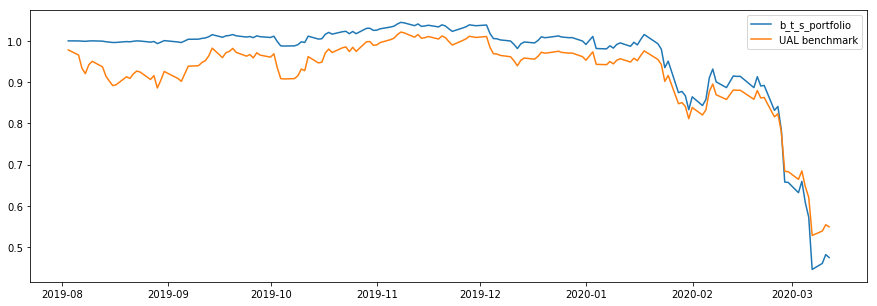

In [39]:
# Plotting UAL benchmark and portfolio cumulative daily returns to understand b_t_s trade strategy performance
plt.figure(figsize=(15,5))
b_t_s_special_portfolio_daily_ret=b_t_s_special_perf.portfolio_value.pct_change()
UAL_daily_ret=b_t_s_special_perf.UAL.pct_change()

plt.plot((1+b_t_s_special_portfolio_daily_ret).cumprod())
plt.plot((1+UAL_daily_ret).cumprod())

plt.legend(('b_t_s_portfolio', 'UAL benchmark'), loc=0)

plt.show()

<Figure size 432x288 with 0 Axes>

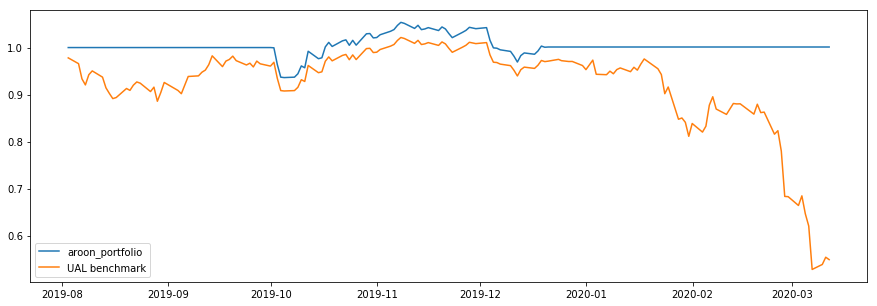

In [40]:
# Plotting UAL benchmark and portfolio cumulative daily returns to understand aroon trade strategy performance
plt.clf()
plt.figure(figsize=(15,5))
aroon_portfolio_special_daily_ret=aroon_special_perf.portfolio_value.pct_change()
UAL_daily_ret=aroon_special_perf.UAL.pct_change()

plt.plot((1+aroon_portfolio_special_daily_ret).cumprod())
plt.plot((1+UAL_daily_ret).cumprod())

plt.legend(('aroon_portfolio', 'UAL benchmark'), loc=0)

plt.show()

<Figure size 432x288 with 0 Axes>

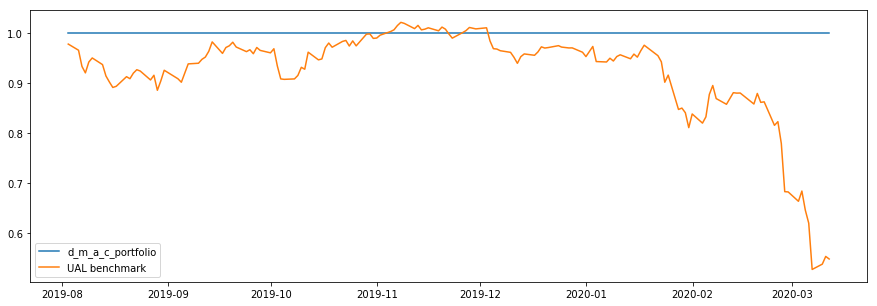

In [41]:
# Plotting UAL benchmark and portfolio cumulative daily returns to understand d_m_a_c_special trade strategy long term performance
plt.clf()
plt.figure(figsize=(15,5))
d_m_a_c_special_portfolio_daily_ret=d_m_a_c_special_perf.portfolio_value.pct_change()
UAL_daily_ret=d_m_a_c_special_perf.UAL.pct_change()

plt.plot((1+d_m_a_c_special_portfolio_daily_ret).cumprod())
plt.plot((1+UAL_daily_ret).cumprod())

plt.legend(('d_m_a_c_portfolio','UAL benchmark'), loc=0)

plt.show()

## Summary on Trading Strategies:
-Unlike previous examples (Part 2) where trading strategies are applied as long term strategy (years), for this case (coroavirus) strategy has only been applied for 7 months (short-mid term) to analyze strategy better especially when airline stocks are greatly affected with less revenue from less travelling due to health awareness regarding current coronavirus issue.

- Blind trading startegy (b_t_s, buy ten stock strategy) would make portfolio worse off as strategy portfolio falls sharply along with airline stock price.

- As for d_m_a_c and arron trading strategy, both startegies did a great job  maintaining startegy portfolio value without executing trade when by indicator values (short_mavg, long_mavg, arron_up, aroon_down), thus being a great strategy in the case of stock price downfall.

- In short, a trading strategy that takes into account of minimizing loss by indicator values would reduce risk of major loss in an economy downturn.